In [2]:
import pandas as pd
import numpy as np
import os
import time
os.chdir('C:/Users/aacraig/Documents/ContextEdge')

In [3]:
from ContextEdge11 import ContextEdgePreprocessor

In [4]:
t0 = time.time()

# -------------------------------------------------------------------------------------------------
# This function returns the dream dataset: 'df', a dictionary of sparse tfidf matrices: 'bow_dict', 
# and a dictionary of feature lists for each text feature: 'features_dict'
# 
# option notes:
# - 'min_proportion': sets value of 'min_df' in TfidfVectorizer
# - 'max_proportion': sets value of 'max_df' in TfidfVectorizer
# - 'ngram_span': sets value of 'ngram_range' in TfidfVectorizer
# - 'perform_tfidf_ops': if set to False, only data cleaning and feature manipulations are performed.
#                        ** The returned objects 'tfidf_dict' and 'tfidf_features_dict' are empty
# - 'mode': either 'lemmatize' or 'stem'
# - 'text_features': list of the text features to include in the tfidf operations
# -------------------------------------------------------------------------------------------------

df, tfidf_dict, tfidf_features_dict = ContextEdgePreprocessor(filename = 'processed_contextedge_input_file.csv', \
                                                                  raw_input_file = False, \
                                                                  min_proportion = 200, \
                                                                  max_proportion = 0.35, \
                                                                  text_features = ['all_scenes_text'],
                                                                  ngram_span = (1,2), \
                                                                  perform_tfidf_ops = True,\
                                                                  mode = 'stem')
t1 = time.time()
print('The function took {} seconds to run.'.format(np.round(t1-t0, decimals = 1)))

No data cleaning was performed, since "raw_input_file" was set to False.


The tfidf fit for the stemmed text feature: all_scenes_text is being generated.
The tfidf fit for the stemmed text feature: all_scenes_text is complete.
There are: 1655 token features in the tfidf model.
The tfidf operations for the feature: all_scenes_text took 19.0 seconds to complete.
The function took 28.0 seconds to run.


#### Looking at the returned dataframe

In [5]:
df.head(2)

,id,name,date,scene_one,scene_two,scene_three,scene_four,location,context,year,month,day,country,state_region,all_scenes_text
0,Journal-000342,The Blood Moon,1980-05-15,Many years into my future I am driving a car t...,This dream happened many years ago but has nev...,NaN,NaN,"Ohio, United States",NaN,1980.0,5.0,15.0,USA,OH,Many years into my future I am driving a car t...
1,Journal-000516,Vison of Jesus Prior to me getting saved,1981-01-10,I was living with my boyfriend at his mothers ...,NaN,NaN,NaN,NaN,NaN,1981.0,1.0,10.0,NaN,NaN,I was living with my boyfriend at his mothers ...


#### Extracting the list of 'all_scenes_text' dream contents

In [6]:
all_dreams = df['all_scenes_text'].tolist()

# NMF Topic Model

#### Getting the tfidf matrix for 'all_scenes_text'

In [7]:
tfidf_matrix = tfidf_dict['all_scenes_text']
tfidf_matrix

<50620x1655 sparse matrix of type '<class 'numpy.float64'>'
	with 1462087 stored elements in Compressed Sparse Row format>

#### Getting the list of feature names for 'all_scenes_text'

In [8]:
tfidf_feature_names = tfidf_features_dict['all_scenes_text']
print('There are: {} features in the tfidf model for "all_scenes_text".'.format(len(tfidf_feature_names)))

There are: 1655 features in the tfidf model for "all_scenes_text".


#### Importing NMF method

In [9]:
from sklearn.decomposition import NMF

#### Setting the number of topics/components for the NMF model to construct from the tfidf model

In [10]:
no_topics = 12

#### Defining the NMF method

In [11]:
nmf = NMF(n_components=no_topics, random_state=42, alpha=0.1, l1_ratio=.2, \
          max_iter = 500, verbose = False, shuffle = True, init='nndsvd', solver = 'cd')

#### Generating the NMF topic model for the tfidf matrix

In [12]:
nmf_model = nmf.fit(tfidf_matrix)

#### Defining a helper function to display topics

In [13]:
def display_nmf_topics(model, feature_names, no_top_words):
    for topic_idx, topic in enumerate(model.components_):
        print ("Topic %d:" % (topic_idx))
        print (" ".join([feature_names[i] for i in topic.argsort()[:-no_top_words - 1:-1]]))

#### Defining a helper function to display top n words for a topic

In [14]:
def top_words(topic, n_top_words):
    return topic.argsort()[:-n_top_words - 1:-1]

#### Setting the number of 'top words' to be displayed for each topic

In [15]:
no_top_words = 40

#### Displaying the topics constructed by the NMF model

In [16]:
display_nmf_topics(nmf_model, tfidf_feature_names, no_top_words)

Topic 0:
im like know dont remember just dont know people think time going really feel didnt real trying life sure tell felt dont remember want ive say look thinking real life getting things means place wake feeling thing says guy looking need way person
Topic 1:
does mean does mean mean dream dream mean dreamt does know know know mean does dream dreaming upwhat upwhat does woke upwhat person dreamed seeing mean thank numbers saw vision money hi pregnant wat number tell mean hello black morning woke teeth friend tell thank anybody question eating dream dream dead
Topic 2:
god spirit lord jesus bless holy word pray god bless holy spirit thank praying love christ life say prayer time things shall today need heard body believe vision heart good gods day power know come hear people world saying help glory voice
Topic 3:
baby pregnant birth boy girl baby girl baby boy holding babies child hospital born little months having gave old care children sister mother arms giving dreamed stomach dre

# Analyzing the topic model

#### Defining function to generate table with topics and specified number of 'top words' for each topic

In [35]:
def topic_table(model, feature_names, n_top_words):
    topics = {}
    for topic_idx, topic in enumerate(model.components_):
        t = ("topic_%d" % topic_idx)
        topics[t] = [feature_names[i] for i in top_words(topic, n_top_words)]
        
    out_df = pd.DataFrame(topics)
    out_df = out_df[list(topics.keys())]
    
    return out_df

#### Generating the topic table

In [36]:
nmf_topic_table = topic_table(nmf_model, tfidf_feature_names, 15)

nmf_topic_table.head()

,topic_0,topic_1,topic_2,topic_3,topic_4,topic_5,topic_6,topic_7,topic_8,topic_9,topic_10,topic_11
0,im,does,god,baby,saw,dreams,car,house,water,said,church,night
1,like,mean,spirit,pregnant,like,having,driving,door,fish,told,pastor,snake
2,know,does mean,lord,birth,white,having dreams,road,room,swimming,went,people,dream night
3,dont,mean dream,jesus,boy,looked,ive,got,outside,clear,husband,service,help
4,remember,dream mean,bless,girl,vision,years,seat,home,pool,came,dream church,dreamt


#### Making labels for the topics

In [37]:
y_labels = ['Topic ' + str(x) for x in range(no_topics)]
y_labels

['Topic 0',
 'Topic 1',
 'Topic 2',
 'Topic 3',
 'Topic 4',
 'Topic 5',
 'Topic 6',
 'Topic 7',
 'Topic 8',
 'Topic 9',
 'Topic 10',
 'Topic 11']

#### Assigning names to the topics in the NMF model

In [38]:
topic_names = [ "I'm Don't Know Like Life", 'What Does This Mean?', 'Christian Theology', 'Pregnancy & Babies',\
                'I Had A Vision', 'Prophetic Dreams', 'Driving & Cars', 'Home & Domesticity', 'Water, Fish, & Swimming',\
                'Nuclear Family', 'Christian Institutions & Community', 'Snakes, Night Setting', 'Danger']
    
topics_names = dict([topic,name ] for (topic, name) in zip(nmf_topic_table.columns.tolist(), topic_names))

In [39]:
topics_names

{'topic_0': "I'm Don't Know Like Life",
 'topic_1': 'What Does This Mean?',
 'topic_10': 'Christian Institutions & Community',
 'topic_11': 'Snakes, Night Setting',
 'topic_2': 'Christian Theology',
 'topic_3': 'Pregnancy & Babies',
 'topic_4': 'I Had A Vision',
 'topic_5': 'Prophetic Dreams',
 'topic_6': 'Driving & Cars',
 'topic_7': 'Home & Domesticity',
 'topic_8': 'Water, Fish, & Swimming',
 'topic_9': 'Nuclear Family'}

#### Stemming all dreams with same procedure as in main function

In [22]:
from nltk.stem import PorterStemmer
# Getting the stemmed documents for this feature
stemmed_dreams = list(map(lambda x: PorterStemmer().stem(str(x)), all_dreams))

#### Defining a tfidf_vectorizer function with same options as specified in main function call

In [23]:
from sklearn.feature_extraction.text import TfidfVectorizer
tfidf_vectorizer = TfidfVectorizer(min_df = 200, max_df = 0.35, ngram_range = (1,2), stop_words = 'english').fit(stemmed_dreams)

#### Using the NMF model to transform the stemmed dreams, generate weights

In [40]:
dream_weights = nmf_model.transform(tfidf_vectorizer.transform(stemmed_dreams))

In [41]:
no_topics

12

#### Visualizing the results

In [42]:
import matplotlib.pyplot as plt

In [43]:
no_dreams_to_plot = 2000

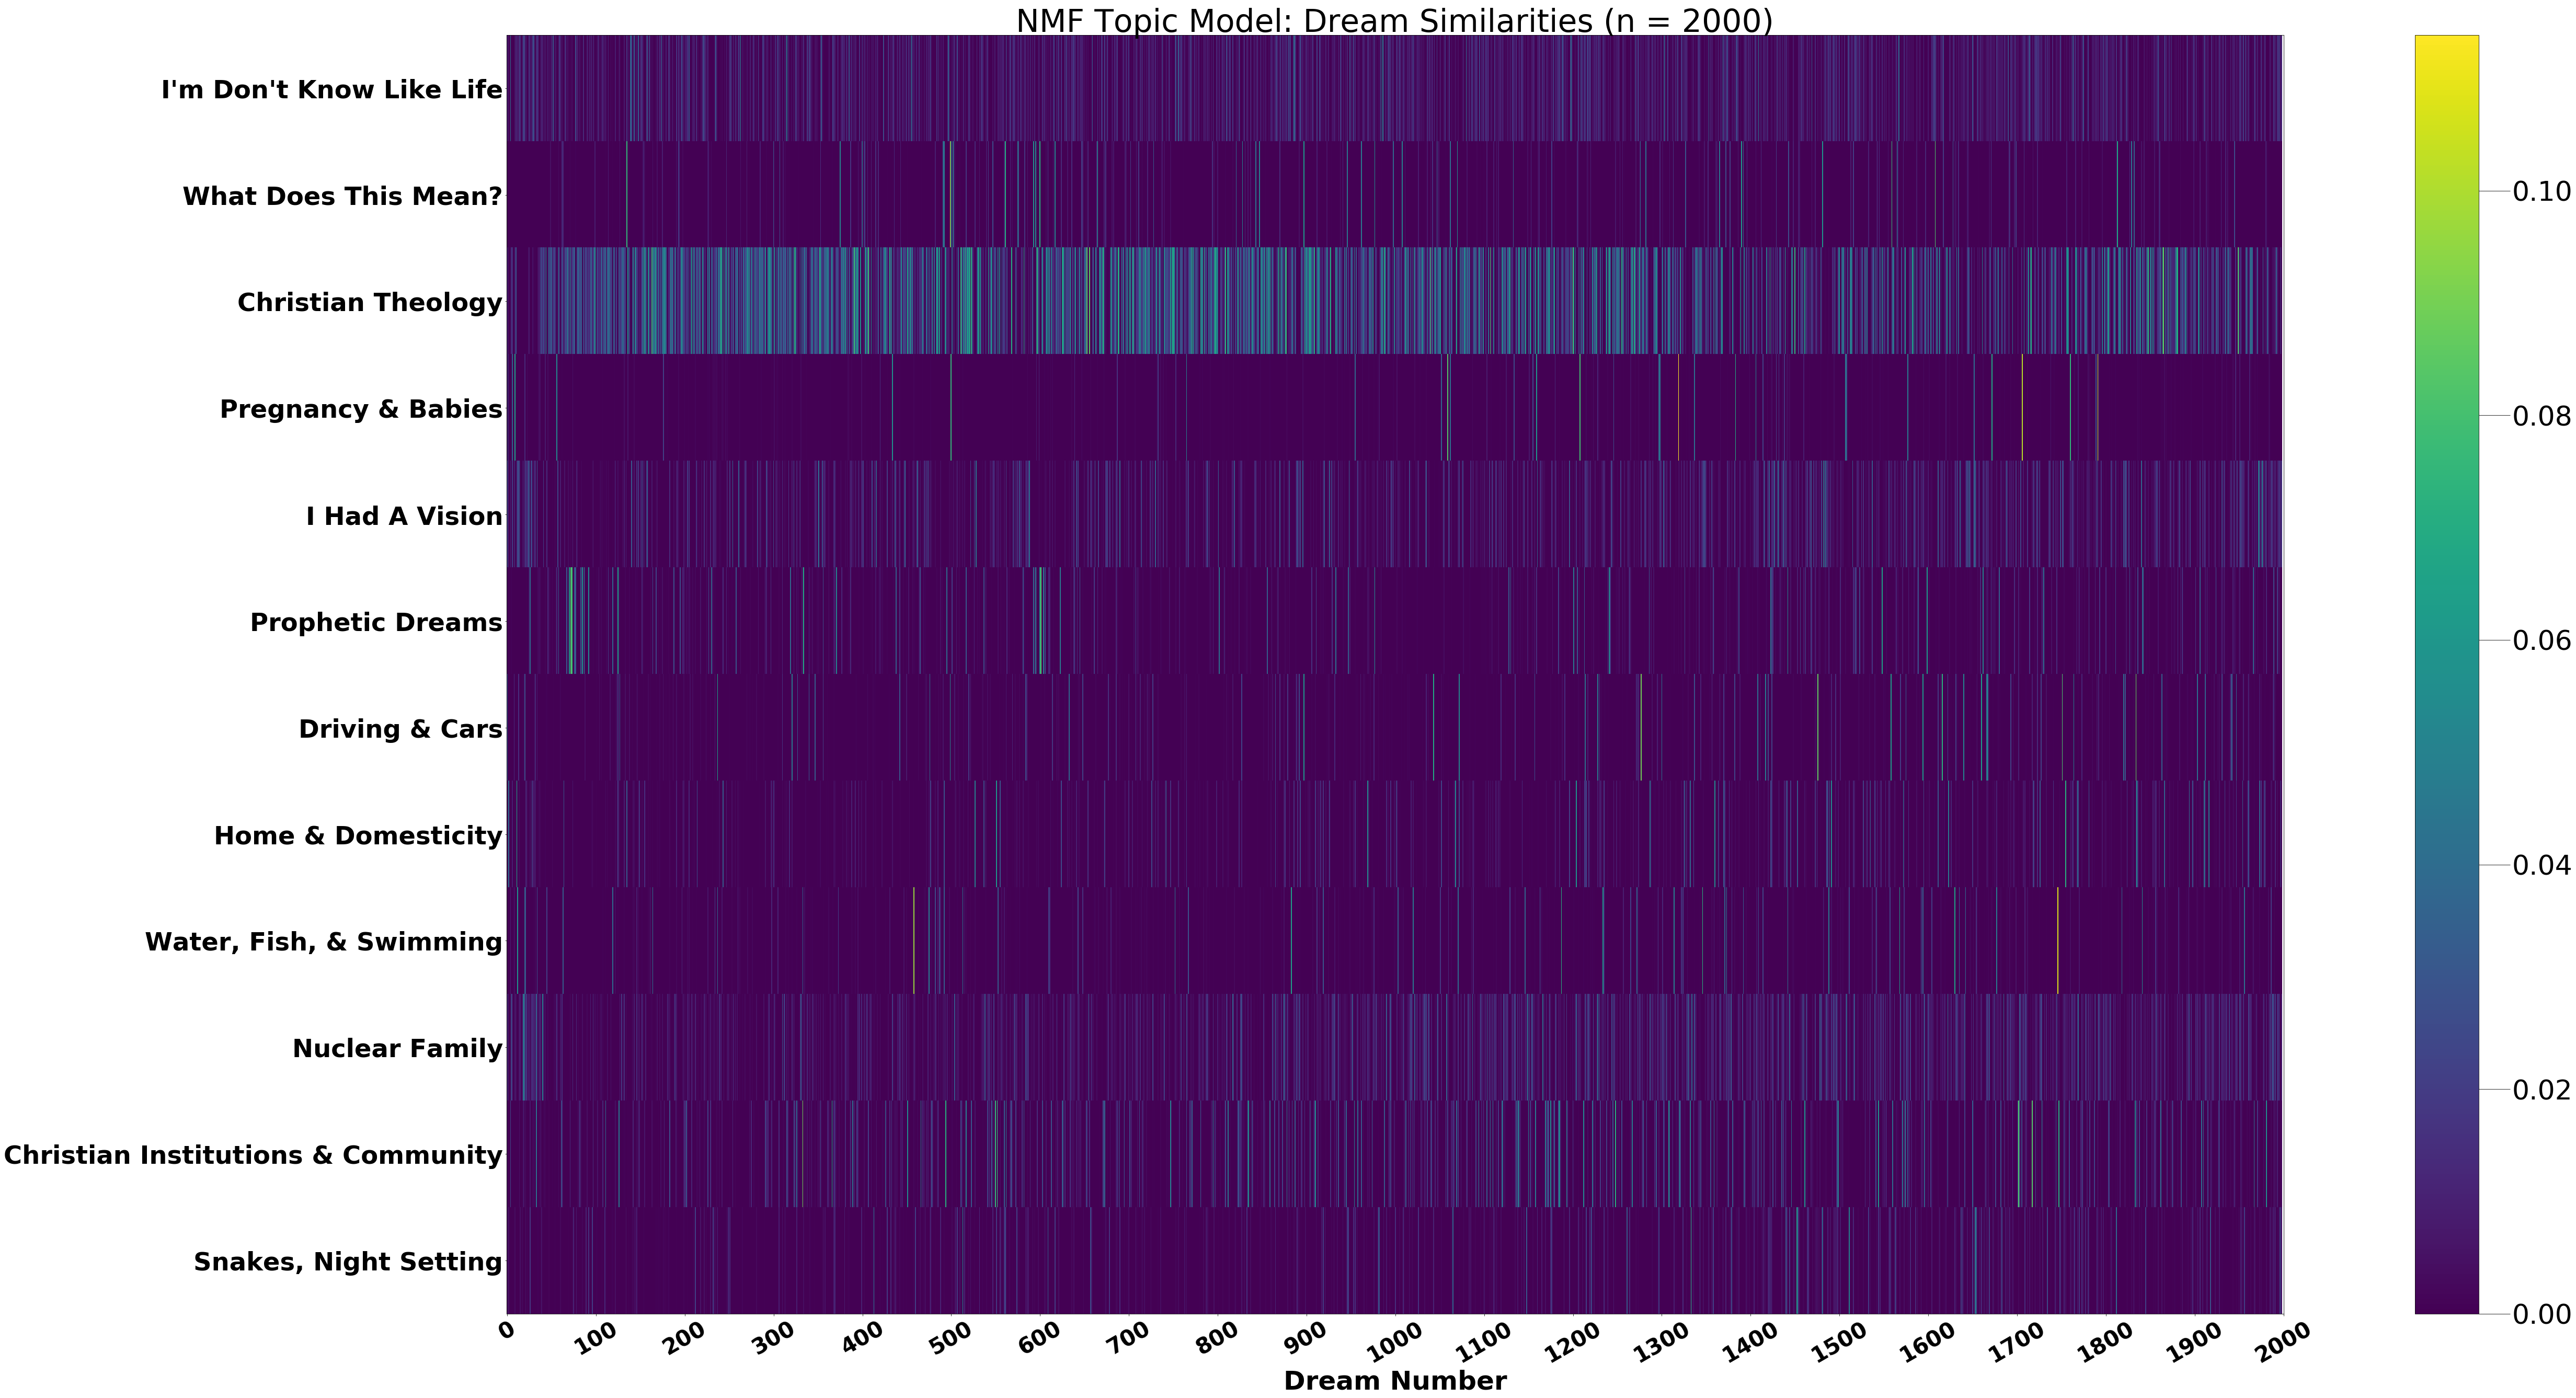

In [44]:
plt.figure(figsize=(90,45))
plt.imshow(dream_weights[0:(no_dreams_to_plot-1), :].T, aspect=120, interpolation='none')
plt.title('NMF Topic Weights', size = 60)
plt.xlabel('Dream Number', size = 50, weight = 'bold')
# plt.ylabel('Topic', size = 54)
plt.title('NMF Topic Model: Dream Similarities (n = {})'.format(no_dreams_to_plot), size = 60)
plt.yticks(np.arange(0,no_topics), topics_names.values(), size = 48, weight = 'bold')
plt.xticks(np.arange(0,no_dreams_to_plot+100, 100),size = 42, rotation = 30, weight = 'bold')

cbar = plt.colorbar()
cbar.ax.tick_params(labelsize=52, size = 60)
plt.savefig('nmf_topic_weights.png')
plt.show()

# Assigning topics to dreams

In [45]:
dream_weights.shape

(50620, 12)

In [46]:
type(dream_weights)

numpy.ndarray

#### Printing the first ten dreams' topics

In [47]:
topics_names

{'topic_0': "I'm Don't Know Like Life",
 'topic_1': 'What Does This Mean?',
 'topic_10': 'Christian Institutions & Community',
 'topic_11': 'Snakes, Night Setting',
 'topic_2': 'Christian Theology',
 'topic_3': 'Pregnancy & Babies',
 'topic_4': 'I Had A Vision',
 'topic_5': 'Prophetic Dreams',
 'topic_6': 'Driving & Cars',
 'topic_7': 'Home & Domesticity',
 'topic_8': 'Water, Fish, & Swimming',
 'topic_9': 'Nuclear Family'}

In [49]:
for n in range(10):
    topic_most_pr = dream_weights[n].argmax()
    # print(topic_most_pr)
    topic_string = 'Topic: ' + topics_names['topic_' + str(topic_most_pr)]
    
    print("dream index: {} topic: {}\n".format(n,topic_string))

dream index: 0 topic: Topic: Driving & Cars

dream index: 1 topic: Topic: Pregnancy & Babies

dream index: 2 topic: Topic: Home & Domesticity

dream index: 3 topic: Topic: I'm Don't Know Like Life

dream index: 4 topic: Topic: I'm Don't Know Like Life

dream index: 5 topic: Topic: Nuclear Family

dream index: 6 topic: Topic: Pregnancy & Babies

dream index: 7 topic: Topic: I'm Don't Know Like Life

dream index: 8 topic: Topic: I Had A Vision

dream index: 9 topic: Topic: Pregnancy & Babies



#### Joining topics to returned dataframe

In [52]:
df['nmf_topic'] = [dream_weights[x].argmax() for x in range(len(df))]
df['nmf_topic_name'] = [topics_names['topic_' + str(dream_weights[x].argmax())] for x in range(len(df))]

# Looking at topic assignments

In [53]:
df['nmf_topic_name'].value_counts()

Nuclear Family                        8080
I Had A Vision                        6768
I'm Don't Know Like Life              6566
Christian Theology                    4720
Snakes, Night Setting                 4045
What Does This Mean?                  3977
Home & Domesticity                    3659
Prophetic Dreams                      2912
Christian Institutions & Community    2648
Driving & Cars                        2610
Water, Fish, & Swimming               2552
Pregnancy & Babies                    2083
Name: nmf_topic_name, dtype: int64

#### Writing the augmented dataframe to disk

In [54]:
df.to_csv("data/dream_data_with_nmf_topics_v1.csv", index = False)